In [1]:
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold,GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score, roc_curve,ConfusionMatrixDisplay,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import roc_curve, auc, classification_report

C:\Users\merow\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Import 2017-08 Data

In [2]:
df=pd.read_csv('green_tripdata_{17}-{8}encoded.csv')

In [3]:
df.head()

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,improvement_surcharge,total_amount,payment_type,trip_type,pickup_datetime,pickup_hour,pickup_day_of_week,duration,duration_seconds,weekend
0,0,2017-08-01 00:21:35,2017-08-01 00:27:59,0,0,0,0,1.0,1.43,7.0,...,0.3,9.96,0,0,2017-08-01 00:21:35,0,1,2024-06-08 00:06:24,384,False
1,0,2017-08-01 00:37:27,2017-08-01 00:39:02,0,0,1,1,1.0,1.09,3.5,...,0.3,4.80,1,0,2017-08-01 00:37:27,0,1,2024-06-08 00:01:35,95,False
2,0,2017-08-01 00:04:03,2017-08-01 00:05:45,0,0,2,2,1.0,1.09,3.5,...,0.3,4.80,1,0,2017-08-01 00:04:03,0,1,2024-06-08 00:01:42,102,False
3,0,2017-08-01 00:05:23,2017-08-01 00:09:20,0,0,0,0,2.0,1.12,5.5,...,0.3,8.16,0,0,2017-08-01 00:05:23,0,1,2024-06-08 00:03:57,237,False
4,0,2017-08-01 00:29:09,2017-08-01 00:34:44,0,0,3,3,2.0,1.09,6.0,...,0.3,7.30,1,0,2017-08-01 00:29:09,0,1,2024-06-08 00:05:35,335,False


In [3]:
# Determine the quantiles for categorizing price range
low_threshold = df['total_amount'].quantile(0.33)
medium_threshold = df['total_amount'].quantile(0.66)

# Define the price range based on quantiles
def categorize_price(total_amount):
    if total_amount <= low_threshold:
        return 'low'
    elif low_threshold < total_amount <= medium_threshold:
        return 'medium'
    else:
        return 'high'

# Apply the function to the DataFrame
df['price_range'] = df['total_amount'].apply(categorize_price)

# Inspect the DataFrame to check the new column
print(df[['total_amount', 'price_range']].head())
print(df['price_range'].value_counts())


   total_amount price_range
0          9.96      medium
1          4.80         low
2          4.80         low
3          8.16         low
4          7.30         low
price_range
low       294507
high      293801
medium    278465
Name: count, dtype: int64


## Pre-processing of the dataset

#### Split Data into Training and Testing Sets

In [4]:
# Convert datetime columns to datetime objects
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
# Extract datetime features
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['lpep_pickup_datetime'].dt.day
df['pickup_month'] = df['lpep_pickup_datetime'].dt.month
df['dropoff_hour'] = df['lpep_dropoff_datetime'].dt.hour
df['dropoff_day'] = df['lpep_dropoff_datetime'].dt.day
df['dropoff_month'] = df['lpep_dropoff_datetime'].dt.month
# Drop the original datetime columns
df=df.drop(columns=['total_amount','fare_amount','mta_tax','tip_amount','extra','tolls_amount','improvement_surcharge','lpep_pickup_datetime', 'lpep_dropoff_datetime','duration','pickup_datetime'])

In [6]:
df.head()

,vendor,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,payment_type,trip_type,pickup_hour,pickup_day_of_week,duration_seconds,weekend,price_range,pickup_day,pickup_month,dropoff_hour,dropoff_day,dropoff_month
0,0,0,0,0,0,1.0,1.43,0,0,0,1,384,False,medium,1,8,0,1,8
1,0,0,0,1,1,1.0,1.09,1,0,0,1,95,False,low,1,8,0,1,8
2,0,0,0,2,2,1.0,1.09,1,0,0,1,102,False,low,1,8,0,1,8
3,0,0,0,0,0,2.0,1.12,0,0,0,1,237,False,low,1,8,0,1,8
4,0,0,0,3,3,2.0,1.09,1,0,0,1,335,False,low,1,8,0,1,8


In [7]:
print(df.columns)

Index(['vendor', 'store_and_fwd_flag', 'rate_type', 'pu_location',
       'do_location', 'passenger_count', 'trip_distance', 'payment_type',
       'trip_type', 'pickup_hour', 'pickup_day_of_week', 'duration_seconds',
       'weekend', 'price_range', 'pickup_day', 'pickup_month', 'dropoff_hour',
       'dropoff_day', 'dropoff_month'],
      dtype='object')


In [5]:
# Separate features and target
x = df.drop(columns=['price_range'])
y = df['price_range']

# Define categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing to the data
X = preprocessor.fit_transform(x)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and testing sets
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(693418, 17) (173355, 17)
(693418,) (173355,)


## Implement Algorithms

### Random Forests Classification

In [6]:
# Initialize the Random Forest classifier
rf = rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=4, min_samples_leaf=2)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

        high       0.95      0.94      0.95     58871
         low       0.94      0.93      0.94     58636
      medium       0.87      0.89      0.88     55848

    accuracy                           0.92    173355
   macro avg       0.92      0.92      0.92    173355
weighted avg       0.92      0.92      0.92    173355



#### Visualize the first tree in the Random Forest

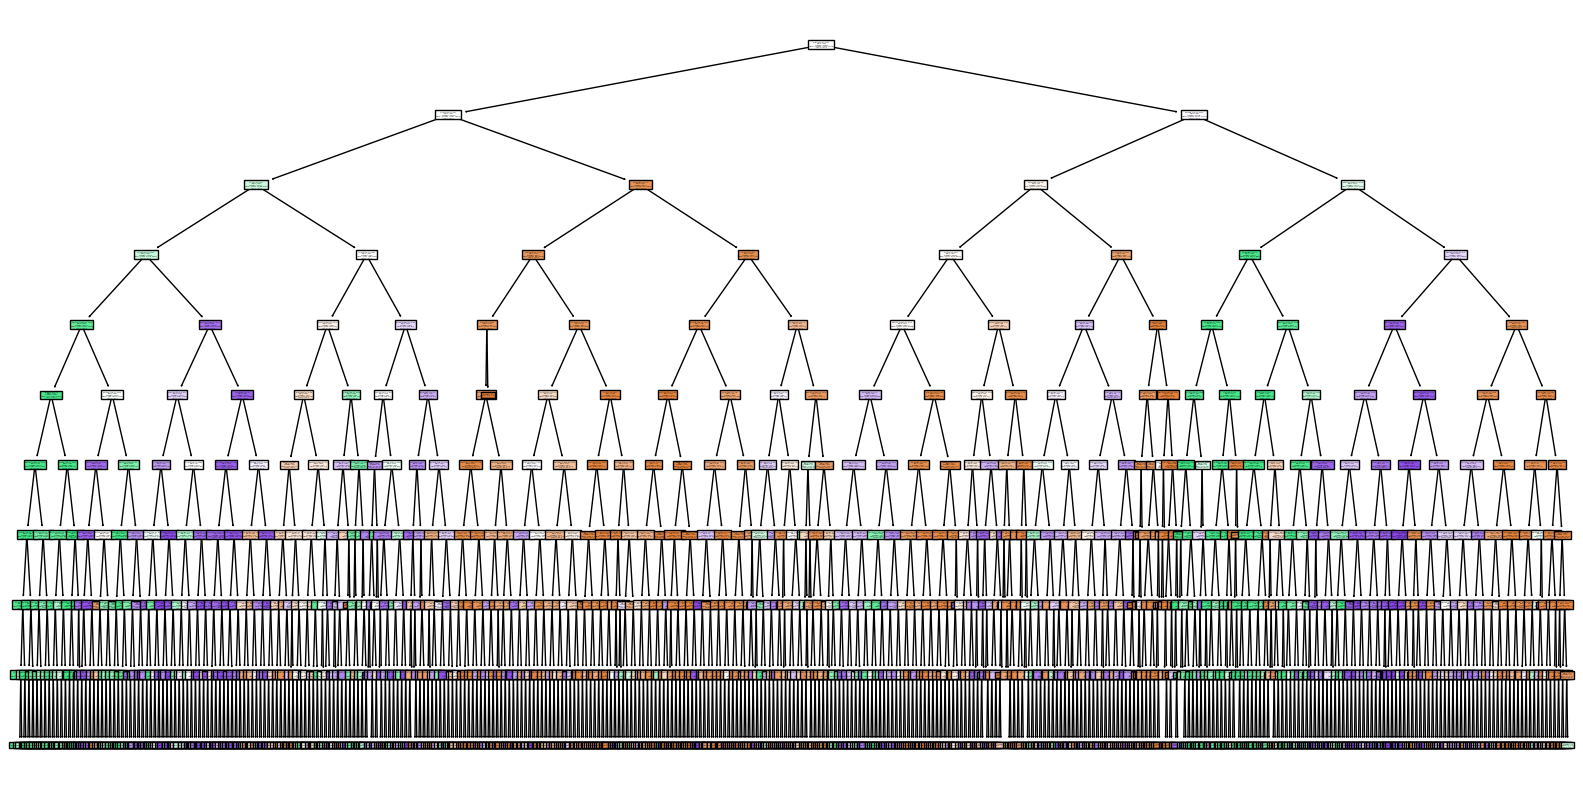

In [19]:
# Visualize the first tree in the Random Forest
feature_names = list(x)

plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=feature_names, class_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'], filled=True)
plt.show()


#### Visualizing Feature Importance

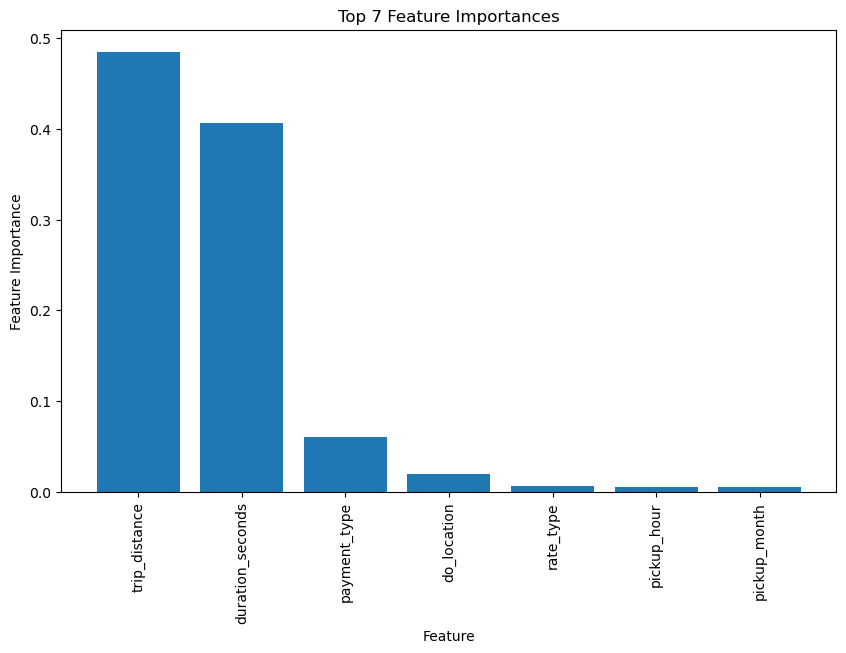

In [20]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select the top 7 most important features
top_n = 7
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = np.array(feature_names)[top_indices]  # Assuming 'feature_names' contains the names of your features

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 7 Feature Importances")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_feature_names, rotation='vertical')  # Plot feature names vertically
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.show()

### Function to Plot Confusion Matrix

In [14]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

### Plot Algorithm

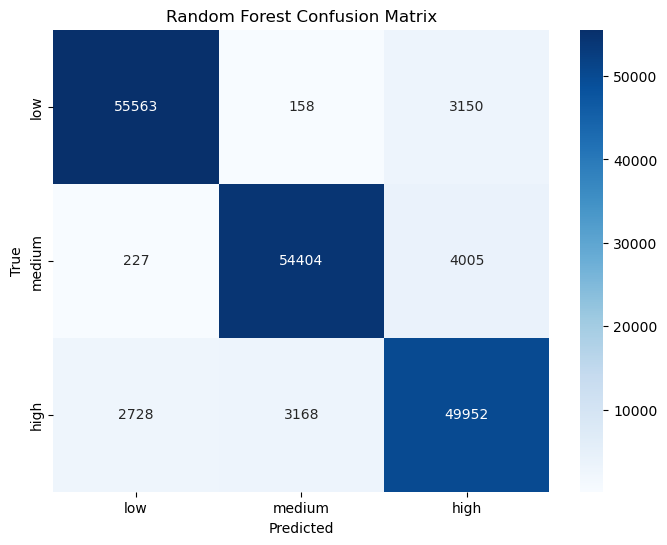

In [15]:
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

#### Cross Validation

In [16]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)  # You can adjust the number of folds (cv) as needed
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Cross-Validation Scores: [0.92068299 0.92151943 0.92349995 0.9211341  0.92030727]
Mean Cross-Validation Score: 0.9214287472553856


#### Learning Curve

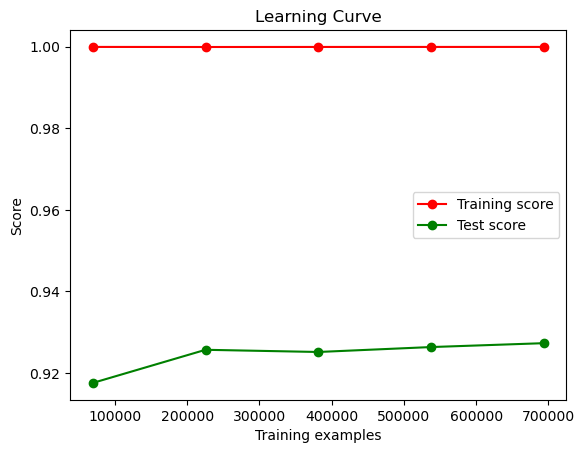

In [10]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Test score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve')
plt.show()

#### ROC Curve

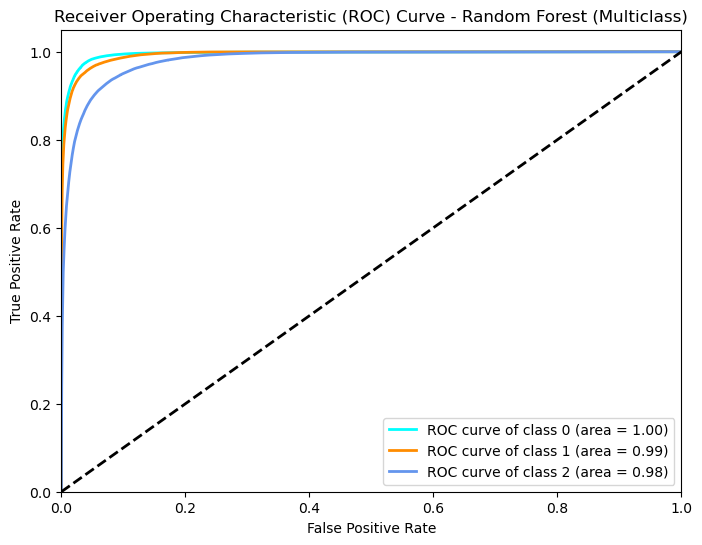

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Assuming you have already imported and split your data
# Let's assume y_train and y_test are your targets

# Binarize the output
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_bin.shape[1]

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Train the model
rf.fit(X_train, y_train)

# Predict probabilities for the test set
y_prob_rf = rf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest (Multiclass)')
plt.legend(loc="lower right")
plt.show()